Here are all libraries which are used for this Data Frame analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

# A. Data Load Section

In [2]:

# File path to the dataset
FILE_PATH = './Data/NYC_Citywide_Rolling_Calendar_Sales_20251203.csv'

df = pd.read_csv(FILE_PATH)

# Check first 5 rows of the dataset
df.head()


C:\Users\User\AppData\Local\Temp\ipykernel_40256\1482498026.py:4: DtypeWarning: Columns (11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(FILE_PATH)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,01 ONE FAMILY DWELLINGS,1,376,43,NaN,S1,743 EAST 6 STREET,NaN,...,1,1.0,2,"2,090","3,680",1940.0,1,S1,$0,01/23/2025
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,372,19,NaN,C7,"292 EAST 3 STREET, 4B",NaN,...,9,1.0,10,"2,401","6,920",1920.0,2,C7,$0,02/07/2025
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,396,26,NaN,C4,638 EAST 14 STREET,NaN,...,20,0.0,20,"2,779","10,740",1920.0,2,C4,$0,05/01/2025
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,396,27,NaN,C4,640 EAST 14 STREET,NaN,...,20,0.0,20,"2,831","10,900",1920.0,2,C4,$0,05/01/2025
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,400,11,NaN,C4,"510 EAST 5TH STREET, 9",NaN,...,18,0.0,18,"2,404","6,875",1900.0,2,C4,"$280,000",04/29/2025


In [4]:
# Check data types and non-null counts
df.info()

# Initial Check on the key columns based on the file snippet:
print("\n--- Check on key columns for cleaning ---")
print(f"SALE PRICE unique values (first 10): {df['SALE PRICE'].unique()[:10]}")
print(f"GROSS SQUARE FEET unique values (first 10): {df['GROSS SQUARE FEET'].unique()[:10]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79884 entries, 0 to 79883
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         79884 non-null  int64  
 1   NEIGHBORHOOD                    79884 non-null  object 
 2   BUILDING CLASS CATEGORY         79884 non-null  object 
 3   TAX CLASS AT PRESENT            79884 non-null  object 
 4   BLOCK                           79884 non-null  int64  
 5   LOT                             79884 non-null  object 
 6   EASE-MENT                       0 non-null      float64
 7   BUILDING CLASS AT PRESENT       79884 non-null  object 
 8   ADDRESS                         79884 non-null  object 
 9   APARTMENT NUMBER                19539 non-null  object 
 10  ZIP CODE                        79863 non-null  float64
 11  RESIDENTIAL UNITS               59938 non-null  object 
 12  COMMERCIAL UNITS                

Based on the output, the dataset has missing values and some of the columns are represented as objects, which probably means there are white spaces or other symbols like $ sign. These things should be cleaned before training a model.

Lets now clean the data!

In [ ]:
cols_to_clean = [
  'SALE PRICE',
  'LAND SQUARE FEET',
  'GROSS SQUARE FEET',
  'TOTAL UNITS',
  'RESIDENTIAL UNITS',
  'COMMERCIAL UNITS'
  ]

for col in cols_to_clean:
  # Here we remove non-numeric characters (commas, dollar signs) and replace missing values with NaN
  df[col] = df[col].astype(str).str.replace(r'[$,-]', '', regex=True).str.strip()
  df[col] = df[col].replace('', np.nan)
  # Convert to numeric, coercing errors to NaN
  df[col] = pd.to_numeric(df[col], errors='coerce')


# Filter out non-market sales (Example: Sale Price = 0 or NaN) and extreme outliers
# So we keep only sales > $10,000 and valid Gross Square Feet
df_cleaned = df[(df['SALE PRICE'].notna()) & (df['SALE PRICE'] > 10000) & (df['GROSS SQUARE FEET'].notna())].copy()

# Log Transform the Target Variable (SALE PRICE)
df_cleaned['LOG_SALE_PRICE'] = np.log(df_cleaned['SALE PRICE'] + 1)

# Here we match Borough code to names for better understanding when visualizing. These values are based on NYC goverment standards 
# used by NYC goverment for administrative and geographical data.
borough_map = {1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens', 5: 'Staten Island'}
df_cleaned['BOROUGH_NAME'] = df_cleaned['BOROUGH'].map(borough_map)

# Check the cleaned data
df_cleaned.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,LOG_SALE_PRICE,BOROUGH_NAME
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,400,11,NaN,C4,"510 EAST 5TH STREET, 9",NaN,...,18.0,2404.0,6875.0,1900.0,2,C4,280000,04/29/2025,12.542548,Manhattan
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,36,NaN,C4,106 AVENUE B,NaN,...,10.0,1919.0,7810.0,1900.0,2,C4,2000000,03/13/2025,14.508658,Manhattan
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,60,NaN,C7,511 EAST 6TH STREET,NaN,...,9.0,2150.0,6152.0,1920.0,2,C7,3400000,12/18/2024,15.039286,Manhattan
8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,404,42,NaN,C4,327 EAST 10 STREET,NaN,...,10.0,2369.0,6990.0,1900.0,2,C4,4000000,08/07/2025,15.201805,Manhattan
10,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,32,NaN,C7,224 AVENUE B,NaN,...,28.0,4172.0,15174.0,1905.0,2,C7,13000000,03/24/2025,16.380460,Manhattan


# B. Exploratory Data Analysis (EDA)


--- Statistical Summary of Key Numerical Columns ---
                     count        mean          std      min       25%  \
SALE PRICE         23071.0  2377307.21  16036142.06  10100.0  700000.0   
LAND SQUARE FEET   23071.0     4463.28     52317.90      0.0    2000.0   
GROSS SQUARE FEET  23071.0     5845.73     35960.22      0.0    1350.0   
YEAR BUILT         22178.0     1941.86        31.35   1826.0    1920.0   
TOTAL UNITS        23071.0        4.25        25.15      0.0       1.0   

                        50%        75%           max  
SALE PRICE         955000.0  1490000.0  1.080000e+09  
LAND SQUARE FEET     2500.0     4000.0  7.446955e+06  
GROSS SQUARE FEET    1936.0     2858.0  1.545708e+06  
YEAR BUILT           1931.0     1960.0  2.025000e+03  
TOTAL UNITS             2.0        2.0  1.276000e+03  


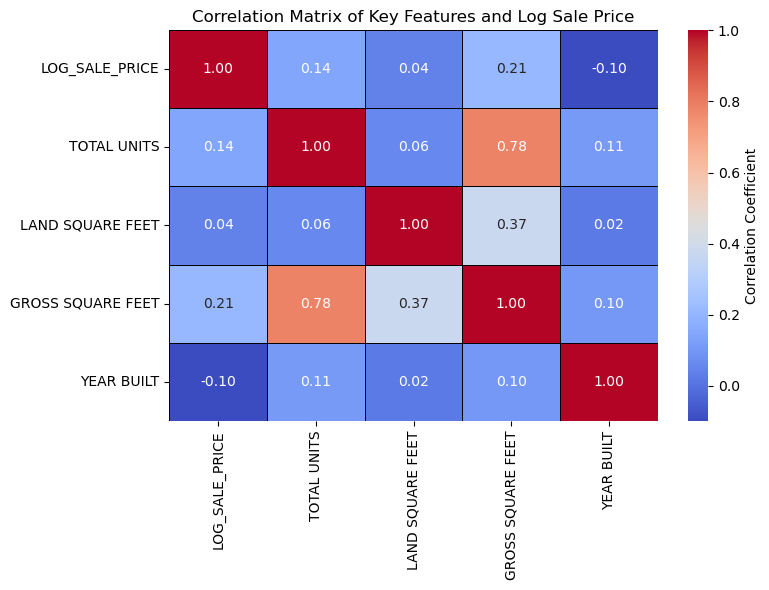

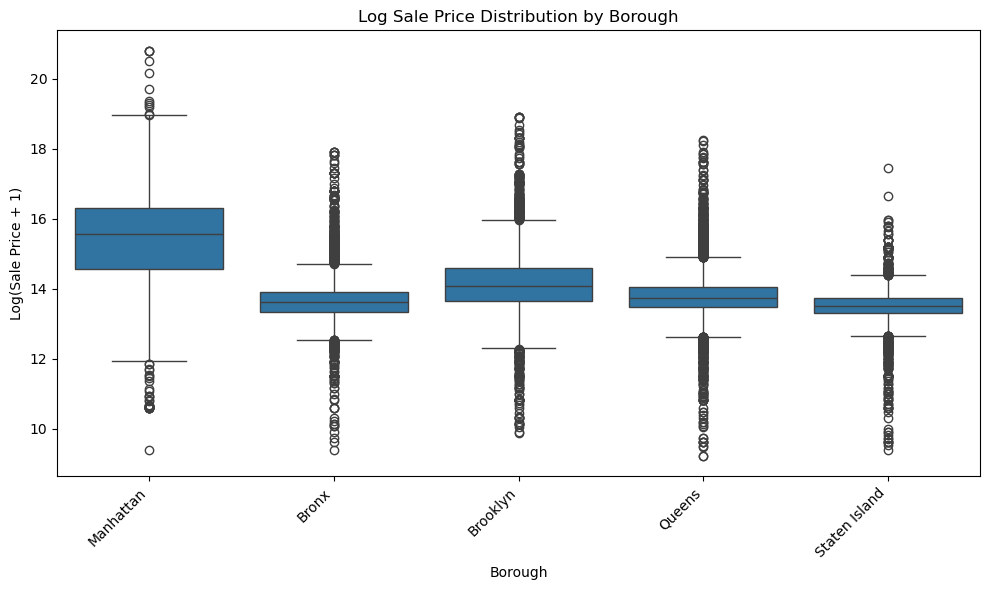

In [7]:
# Statistical Summary Data 
print("\n--- Statistical Summary of Key Numerical Columns ---")
print(df_cleaned[['SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TOTAL UNITS']].describe().T.round(2))

# Correlation Matrix 
numerical_cols = ['LOG_SALE_PRICE', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']
corr_matrix = df_cleaned[numerical_cols].corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Key Features and Log Sale Price')
plt.tight_layout()
plt.show()

# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='BOROUGH_NAME', y='LOG_SALE_PRICE', data=df_cleaned)
plt.title('Log Sale Price Distribution by Borough')
plt.xlabel('Borough')
plt.ylabel('Log(Sale Price + 1)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Now, lets save the cleaned DataFrame for the next steps 
df_cleaned.to_csv('nyc_sales_cleaned_fixed.csv', index=False)

# C.  Data Preparation

In [9]:

# --------------- Part - Feature Engineering --------------
CURRENT_YEAR = 2025
df_cleaned = pd.read_csv('./nyc_sales_cleaned_fixed.csv')

# 1. Numerical columns fix
numerical_cols_for_fix = ['TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'SALE PRICE', 'YEAR BUILT']
for col in numerical_cols_for_fix:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
    
# 2. Categorical columns fix 
categorical_features_for_fix = ['BOROUGH_NAME', 'BUILDING CLASS CATEGORY', 'ZIP CODE']
for col in categorical_features_for_fix:
    df_cleaned[col] = df_cleaned[col].astype(str).replace('nan', np.nan)
# -----------------------------------------------------------

# Creating a new feature - AGE 
df_cleaned['AGE'] = CURRENT_YEAR - df_cleaned['YEAR BUILT']
# If the age is negative, then its NaN
df_cleaned.loc[df_cleaned['AGE'] < 0, 'AGE'] = np.nan


# --------------- Part: Correcting Error Data ---------------
for col in ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'TOTAL UNITS']:
    df_cleaned[col] = df_cleaned[col].replace(0, np.nan)

# Define the final target and feature lists
TARGET = 'LOG_SALE_PRICE'
FEATURES = [
    'BOROUGH_NAME', 'BUILDING CLASS CATEGORY', 'ZIP CODE', 'AGE',
    'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET',
    'RESIDENTIAL UNITS', 'COMMERCIAL UNITS'
]

X = df_cleaned[FEATURES]
y = df_cleaned[TARGET]


# Data Splitting - 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data splitted: Training set size: {len(X_train)}, Test set size: {len(X_test)}")


# ----------- Part: Dealing with Missing Values and Scaling  ---------------

numerical_features = ['AGE', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS']
categorical_features = ['BOROUGH_NAME', 'BUILDING CLASS CATEGORY', 'ZIP CODE']

# Here we replace missing num values with median and scale the numerical features
# Median is used because it is stbale against outliers
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler()) 
])


# Here we replace missing categorical values with 'missing' and apply One-Hot Encoding
# One-Hot Encoding is used to convert categorical values into a binary format which is suitable for ML algorithms
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# here we combine both numerical and categorical pipelines into a ColumnTransformer 
# This will allow us to preprocess both types of data appropriately in one step
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='drop'  # we drop any other columns that are not specified
)

# Initialize dictionary to store predictions for Section E
# Dictionary to hold model predictions for evaluation
model_predictions = {}

print("Section C completed!")

Data splitted: Training set size: 18456, Test set size: 4615
Section C completed!


# D. Model Training 

In [10]:
# 1. Multiple Linear Regression Pipeline
mlr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 2. Training the model
print("--- Training Multiple Linear Regression ---")
mlr_pipeline.fit(X_train, y_train)

# 3. Predict on the test set and store results
y_pred_mlr = mlr_pipeline.predict(X_test)
model_predictions['MLR'] = y_pred_mlr

# 4. Saving the model for later deployment
joblib.dump(mlr_pipeline, 'MLR_pipeline.pkl')
print("Multiple Linear Regression trained and saved!")

# 5. Output the first 10 predictions
print(y_pred_mlr[:10])




--- Training Multiple Linear Regression ---
Multiple Linear Regression trained and saved!
[13.93721829 14.24806941 13.52012971 14.10189807 13.63784476 13.75676442
 13.74549171 13.61664374 13.66501711 14.57884924]


In [12]:
# 2. Random Forest Regressor Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', joblib.load('preprocessor_pipeline.pkl')), # Load the preprocessor
    ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# 2. Defining the tuning grid
# Tuning grid is defined to search for the best hyperparameters for the Random Forest model
param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20],
    'regressor__min_samples_split': [5, 10]
}

# 3. Here we perform Randomized Search Tuning
print("--- Training and Tuning Random Forest Regressor ---")
tuner_rf = RandomizedSearchCV(
    rf_pipeline, 
    param_distributions=param_grid_rf, # using the defined tuning grid 
    n_iter=5, cv=3,  #number of iterations and cross validation folds. cross validation helps in assessing the model's performance more reliably
    scoring='neg_mean_squared_error', #we use negative mean squared error as the scoring metric for regression tasks
    verbose=0, n_jobs=-1, random_state=42 # verbosity, parallel jobs, and random state for reproducibility. parrallel jobs is negative because we want to use all available cores
)
tuner_rf.fit(X_train, y_train)
best_rf_model = tuner_rf.best_estimator_
print(f"Best parameters found: {tuner_rf.best_params_}")

# 4. Predict on the test set and store results
y_pred_rf = best_rf_model.predict(X_test)
model_predictions['Random_Forest'] = y_pred_rf

# 5. Saving the best model
joblib.dump(best_rf_model, 'Random_Forest_pipeline.pkl')
print("Random Forest Regressor tuned and saved.")

# 6. Output the first 10 predictions
print(y_pred_rf[:10])

--- Training and Tuning Random Forest Regressor ---
Best parameters found: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 10, 'regressor__max_depth': 20}
Random Forest Regressor tuned and saved.
[13.68182243 14.30844187 13.5390175  14.02214805 13.6173732  13.53773432
 13.80487795 13.49143254 13.51791929 13.87725016]


In [13]:
# 1. KNN Regressor Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', joblib.load('preprocessor_pipeline.pkl')), # Load the preprocessor
    ('regressor', KNeighborsRegressor(n_jobs=-1))
])

# 2. Define the tuning grid
param_grid_knn = {
    'regressor__n_neighbors': [5, 10, 20],
    'regressor__weights': ['uniform', 'distance']
}

# 3. Perform Randomized Search Tuning
print("--- Training and Tuning K-Nearest Neighbors Regressor ---")
tuner_knn = RandomizedSearchCV(
    knn_pipeline, 
    param_distributions=param_grid_knn, # using the defined tuning grid
    n_iter=5, cv=3, 
    scoring='neg_mean_squared_error', 
    verbose=0, n_jobs=-1, random_state=42
)
tuner_knn.fit(X_train, y_train)
best_knn_model = tuner_knn.best_estimator_
print(f"Best parameters found: {tuner_knn.best_params_}")

# 4. Predict on the test set and store results
y_pred_knn = best_knn_model.predict(X_test)
model_predictions['KNN_Regression'] = y_pred_knn

# 5. Save the best model
joblib.dump(best_knn_model, 'KNN_Regression_pipeline.pkl')
print("KNN Regressor tuned and saved.")

# 6. Output the first 10 predictions
print(y_pred_knn[:10])

--- Training and Tuning K-Nearest Neighbors Regressor ---
Best parameters found: {'regressor__weights': 'uniform', 'regressor__n_neighbors': 10}
KNN Regressor tuned and saved.
[13.89401653 14.47799461 13.54747183 13.9565259  13.67032572 13.77384447
 13.72465234 13.54159033 13.41356038 14.97037301]


# E: Model Evaluation

In [16]:
# evaluation_results will hold the evaluation metrics for each model
evaluation_results = []

# Prepare the actual Y values in dollars for the Median Absolute Error calculation
y_test_dollars = np.exp(y_test) - 1 

# Looping through stored predictions
for name, y_pred in model_predictions.items():
    # 1. Calculating Metrics on LOG_SALE_PRICE (RMSE and R-squared)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # 2. Calculate Median Absolute Error in actual dollars for interpretation
    y_pred_dollars = np.exp(y_pred) - 1
    mae_dollars = np.median(np.abs(y_test_dollars - y_pred_dollars))
    
    evaluation_results.append({
        'Model': name,
        'RMSE (Log)': round(rmse_log, 4),
        'R-squared': round(r2, 4),
        'Median_Absolute_Error ($)': round(mae_dollars, 0)
    })

# Evaluation results table:
results_df = pd.DataFrame(evaluation_results).sort_values(by='R-squared', ascending=False)
print("\n--- Model Evaluation Summary ---")
print(results_df.to_markdown(index=False))

# Save the results table
results_df.to_csv('model_evaluation_results_final.csv', index=False)
print("Final model evaluation results are saved to the 'model_evaluation_results_final.csv'")


--- Model Evaluation Summary ---
| Model          |   RMSE (Log) |   R-squared |   Median_Absolute_Error ($) |
|:---------------|-------------:|------------:|----------------------------:|
| Random_Forest  |       0.5843 |      0.5682 |                      198631 |
| KNN_Regression |       0.6307 |      0.4969 |                      220799 |
| MLR            |       0.6607 |      0.4479 |                      234180 |
Final model evaluation results are saved to the 'model_evaluation_results_final.csv'
